# SMuRF Phase Noise 

## Imports/Function Definitions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import yaml
from matplotlib import cm
plt.rcParams["font.family"] = "serif"

In [5]:
def read_csv(fname):
    '''
    Function from reading in csv file in format from fieldfox spectrum analyzer.
    Arguments:
        fname (str): Input file name
    Returns:
        f (int arr): Frequency points
        p (float arr): SA data points in dBm
    '''
    f = []
    p = []
    for line in open(fname):
        if line[0] == '!':
            continue
        if 'BEGIN' in line:
            continue
        if 'END' in line:
            continue
        f.append(int(line.split(',')[0]))
        p.append(float(line.split(',')[1]))
    return np.asarray(f), np.asarray(p)

In [6]:
def sub_spec(p1,p2):
    '''
    Function for subtracting one spectrum from another.
    Arguments:
        p1 (float arr): SA data points in dBm
        p2 (float arr): SA data points in dBm
    Returns:
        pret (float arr): p1-p2 in dBm units
    '''
    p1lin = 10**(p1/10)
    p2lin = 10**(p2/10)
    pret = p1lin - p2lin
    return 10*np.log10(pret)

In [7]:
def get_phase_noise(f,p,RBW):
    '''
    Function for getting the double sided phase noise profile from an input power spectrum.
    Arguments:
        f (int arr): Frequency points
        p (float arr): SA data points in dBm
        RWB (float): Resolution bandwidth used when data was taken.
    Returns:
        fout (float arr): Frequency offset from carrier in Hz
        pn (float arr): Double sided phase noise in dBc/Hz
    '''
    max_idx = np.nanargmax(p)
    len_f_out = min(len(f)-1-max_idx,max_idx)
    pn = np.zeros(len_f_out)
    fout = []
    df = np.mean(np.diff(f))
    nsamp_max_pwr = int(np.floor(40e3/df))
    carrier_pow = 10**(p[max_idx]/10)
    for i in range(nsamp_max_pwr):
        if (np.isnan(p[max_idx + i])) and (np.isnan(p[max_idx - i])):
            continue
        if ~(np.isnan(p[max_idx + i])) and (np.isnan(p[max_idx - i])):
            carrier_pow += 10**(p[max_idx + i]/10)
            continue
        if (np.isnan(p[max_idx + i])) and ~(np.isnan(p[max_idx - i])):
            carrier_pow += 10**(p[max_idx - i]/10)
            continue
        carrier_pow += 10**(p[max_idx + i]/10)
        carrier_pow += 10**(p[max_idx - i]/10) 
    carrier_pow = 10*np.log10(carrier_pow)
    for i in range(len_f_out):
        fout.append((i+1)*df)
        if (np.isnan(p[max_idx + i])) and (np.isnan(p[max_idx - i])):
            pn[i] = np.nan      
            continue
        if np.isnan(p[max_idx + i]) and ~(np.isnan(p[max_idx - i])):
            side = 10*np.log10(2*(10**(p[max_idx + i]/10))/RBW)
            pn[i] = side-carrier_pow          
            continue
        if ~(np.isnan(p[max_idx + i])) and np.isnan(p[max_idx - i]):
            side = 10*np.log10(2*(10**(p[max_idx - i]/10))/RBW)
            pn[i] = side-carrier_pow     
            continue
        side = 10*np.log10((10**(p[max_idx + i]/10) + 10**(p[max_idx - i]/10))/RBW)
        pn[i] = side-carrier_pow
    return np.asarray(fout), pn

## Data from 2021-02-26

### Organizing Input Data

#### Generate dictionary of all datafiles

In [5]:
#For data taken w/ all channels on there are 1256 on
#1 AMC (AMC1) has LPF and other does not (one we're generating 4.25G Tone on)
out_dict = {}
out_dict['Baseline'] = {}
out_dict['Baseline']['122.88_MHz'] = {}
out_dict['Baseline']['122.88_MHz']['SA_Only'] = {}
out_dict['Baseline']['122.88_MHz']['SA_Only']['1MHz BW'] = 'Baseline_SA_122p88_MHz_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['SA_Only']['100kHz BW'] = 'Baseline_SA_122p88_MHz_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['SA_Only']['1GHz BW'] = 'Baseline_SA_122p88_MHz_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['With Filter'] = {}
out_dict['Baseline']['122.88_MHz']['With Filter']['100kHz BW'] = 'Baseline_Tone_with_Filter_122p88_100kBW.csv'
out_dict['Baseline']['122.88_MHz']['With Filter']['1MHz BW'] = 'Baseline_Tone_with_Filter_122p88_1MHzBW.csv'

out_dict['Baseline']['122.88_MHz']['No Filter'] = {}
out_dict['Baseline']['122.88_MHz']['No Filter']['1GHz BW'] = 'Baseline_Tone_No_Filt_122p88_1GBW.csv'
out_dict['Baseline']['122.88_MHz']['No Filter']['100kHz BW'] = 'Baseline_Tone_No_Filt_122p88_100kBW.csv'
out_dict['Baseline']['122.88_MHz']['No Filter']['1MHz BW'] = 'Baseline_Tone_No_Filt_122p88_1MHzBW.csv'

out_dict['Baseline']['4.25_GHz'] = {}
out_dict['Baseline']['4.25_GHz']['SA_Only'] = {}
out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW'] = 'Baseline_SA_4p25_GHz_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW'] = 'Baseline_SA_4p25_GHz_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['With Filter'] = {}
out_dict['Baseline']['4.25_GHz']['With Filter']['1MHz BW'] = 'Baseline_Tone_With_Filt_4p25_1MHzBW.csv'
out_dict['Baseline']['4.25_GHz']['With Filter']['100kHz BW'] = 'Baseline_Tone_With_Filt_4p25_100kBW.csv'
out_dict['Baseline']['4.25_GHz']['No Filter'] = {}
out_dict['Baseline']['4.25_GHz']['No Filter']['1MHz BW'] = 'Baseline_Tone_No_Filter_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['No Filter']['100kHz BW'] = 'Baseline_Tone_No_Filter_4p25_100kBW.csv'

out_dict['Baseline']['4.25_GHz']['No Clock'] = {}
out_dict['Baseline']['4.25_GHz']['No Clock']['100kHz BW'] = 'Baseline_Tone_No_ExtClk_4p25_100kBW.csv'
out_dict['Baseline']['4.25_GHz']['No Clock']['1MHz BW'] = 'Baseline_Tone_No_ExtClk_4p25_1MHz_BW.csv'

out_dict['Baseline']['4.25_GHz']['All_Relock'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['In'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone Off'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone Off']['100kHz BW'] = 'Baseline_AllRelock_In_Coupler_4p25_100k.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone Off']['1MHz BW'] = 'Baseline_AllRelock_In_Coupler_4p25_1M.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone On'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone On']['100kHz BW'] = 'Baseline_Tone_In_Coupler_4p25_100kBW.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['In']['Tone On']['1MHz BW'] = 'Baseline_Tone_In_Coupler_4p25_1MBW.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone Off'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone Off']['100kHz BW'] = 'Baseline_AllRelock_Out_Coupler_4p25_100k.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone Off']['1MHz BW'] = 'Baseline_AllRelock_Out_Coupler_4p25_1M.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone Off']['10MHz BW'] = 'Baseline_AllRelock_Out_Coupler_4p25.csv'
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone On'] = {}
out_dict['Baseline']['4.25_GHz']['All_Relock']['Out']['Tone On']['1MHz BW'] = 'Baseline_Tone_Out_Coupler_4p25_1MBW.csv'

out_dict['Baseline']['4.25_GHz']['All_Tracking'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone On'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone On']['100kHz BW'] = 'Baseline_AllTracking_Out_4p25_100k_TonOn.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone On']['1MHz BW'] = 'Baseline_AllTracking_Out_4p25_1M_TonOn.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone On']['10MHz BW'] = 'Baseline_AllTracking_4p25_Out_10MHz.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone Off'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone Off']['100kHz BW'] = 'Baseline_AllTracking_Out_4p25_100kHz.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['Out']['Tone Off']['1MHz BW'] = 'Baseline_AllTracking_Out_4p25_1MHz.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone On'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone On']['100kHz BW'] = 'Baseline_AllTracking_In_4p25_100k_ToneOn.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone On']['1MHz BW'] = 'Baseline_AllTracking_In_4p25_1M_TonOn.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone Off'] = {}
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone Off']['100kHz BW'] = 'Baseline_AllTracking_In_4p25_100kHz.csv'
out_dict['Baseline']['4.25_GHz']['All_Tracking']['In']['Tone Off']['1MHz BW'] = 'Baseline_AllTracking_In_4p25_1MHz.csv'

out_dict['Baseline']['Neighbor'] = {}
out_dict['Baseline']['Neighbor']['All_Tracking'] = {}
out_dict['Baseline']['Neighbor']['All_Tracking']['Out'] = {}
out_dict['Baseline']['Neighbor']['All_Tracking']['Out']['100kHz BW'] = 'Baseline_AllTracking_Neighbor_Out_100kHz.csv'
out_dict['Baseline']['Neighbor']['All_Tracking']['Out']['1MHz BW'] = 'Baseline_AllTracking_Neighbor_Out_1MHz.csv'
out_dict['Baseline']['Neighbor']['All_Tracking']['In'] = {}
out_dict['Baseline']['Neighbor']['All_Tracking']['In']['100kHz BW'] = 'Baseline_AllTracking_Neighbor_In_100kHz.csv'
out_dict['Baseline']['Neighbor']['All_Tracking']['In']['1MHz BW'] = 'Baseline_AllTracking_Neighbor_In_1MHz.csv'

#### Dump dictionary to yaml

In [30]:
with open('File_Organization.yml', 'w') as outfile:
    yaml.dump(out_dict, outfile, default_flow_style=False)

### Generate Baseline Spectum and Phase Noise Plots

#### Make 122.88MHz Clock Plots

Text(0, 0.5, 'Double Sided Phase Noise [dBc/Hz]')

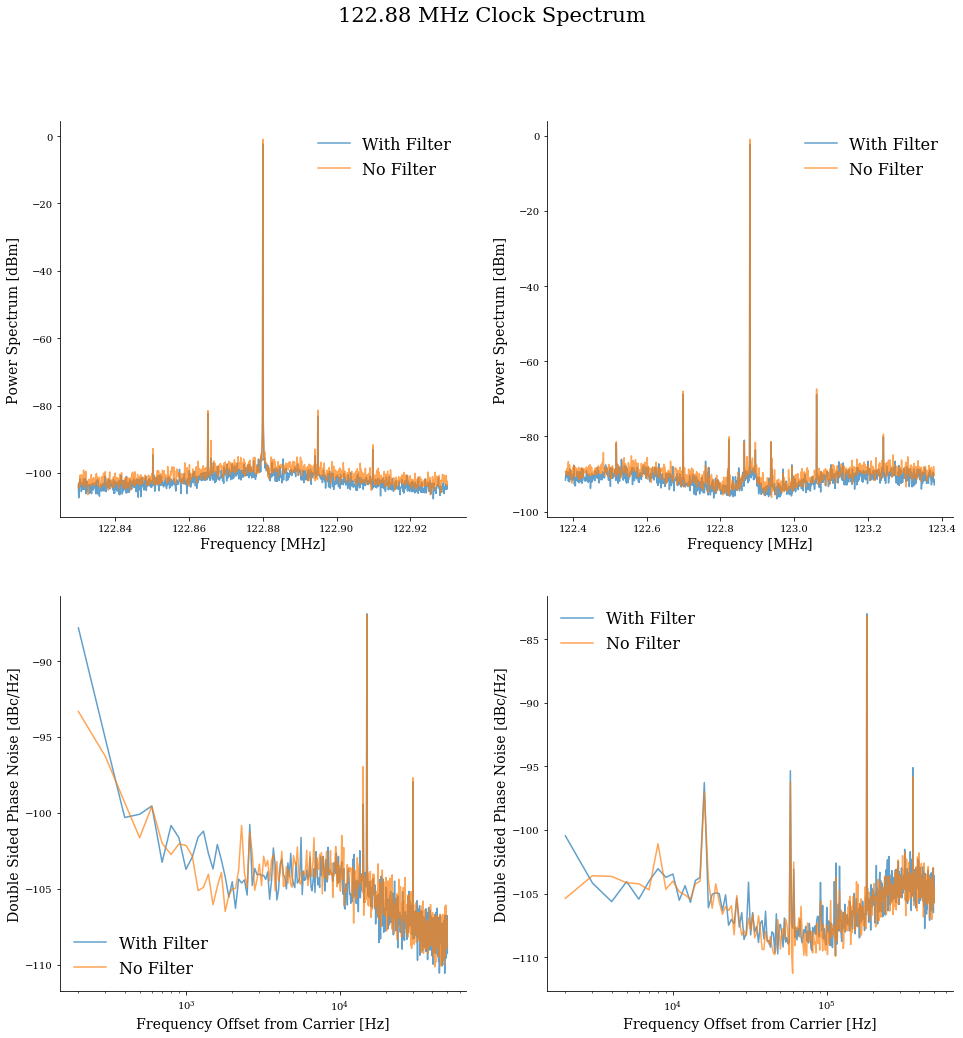

In [6]:
#Initialize plotting stuff.
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

#Get SA baseline noise to subtract away
dirname = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210226/Baseline/'
sa100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)

#Iterate through all data to calc phase noise and plot
for k1 in ['With Filter','No Filter']:
    fname100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['100kHz BW']}"
    fname1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['1MHz BW']}"
    f100k, p100k = read_csv(fname100k)
    dat100k_plot = sub_spec(p100k,sa100k_p)
    f1M, p1M = read_csv(fname1M)
    dat1M_plot = sub_spec(p1M,sa1M_p)
    ax1.plot(f100k/1e6,dat100k_plot,alpha = 0.7,label = f'{k1}')
    ax2.plot(f1M/1e6,dat1M_plot,alpha = 0.7,label = f'{k1}')
    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
    ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,label = f'{k1}')
    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
    ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,label = f'{k1}')
plt.suptitle('122.88 MHz Clock Spectrum', fontsize = 21)
ax1.legend(frameon = False,fontsize = 16)
ax1.set_xlabel('Frequency [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax2.legend(frameon = False,fontsize = 16)
ax2.set_xlabel('Frequency [MHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax3.legend(frameon = False,fontsize = 16)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
ax4.legend(frameon = False,fontsize = 16)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)

#### Make 4.25 GHz Tone Plots

##### Comparing clock filtering with all other tones off

Text(0, 0.5, 'Double Sided Phase Noise [dBc/Hz]')

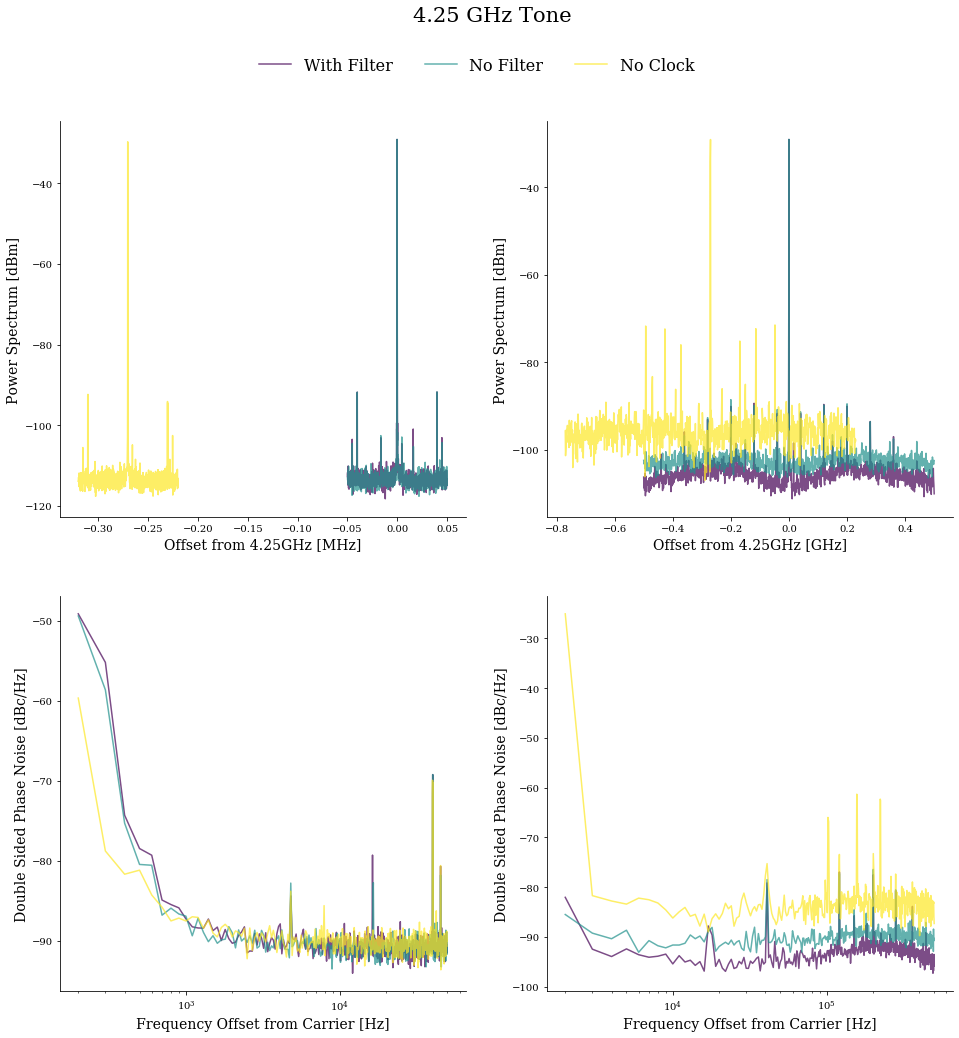

In [7]:
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
viridis = cm.get_cmap('viridis', 3)
colors = viridis(range(3))

dir = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210226/Baseline'
sa100k = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)
cmapn = 0

for k1 in ['With Filter', 'No Filter', 'No Clock']:
    if 'In' in out_dict['Baseline']['4.25_GHz'][k1].keys():
        for k2 in out_dict['Baseline']['4.25_GHz'][k1].keys():
            for k3 in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                #if ~('100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2]['Tone On'].keys()):
                #    continue
                print(k1,k2,k3)
                if '100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['100kHz BW']}"
                    f100k, p100k = read_csv(fname100k)
                    dat100k_plot = sub_spec(p100k,sa100k_p)
                    ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                             color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
                    ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                if '1MHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['1MHz BW']}"
                    f1M, p1M = read_csv(fname1M)
                    dat1M_plot = sub_spec(p1M,sa1M_p)
                    ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                             color = colors[cmapn], label = f'{k1} {k2}\n{k3}')
                    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
                    ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                cmapn += 1
    if not('In' in out_dict['Baseline']['4.25_GHz'][k1].keys()):
        fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['100kHz BW']}"
        fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['1MHz BW']}"
        f100k, p100k = read_csv(fname100k)
        dat100k_plot = sub_spec(p100k,sa100k_p)
        f1M, p1M = read_csv(fname1M)
        dat1M_plot = sub_spec(p1M,sa1M_p)
        ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
        ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
        ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        cmapn += 1

plt.suptitle('4.25 GHz Tone', fontsize = 21)

#plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0, 2.45))
ax1.set_xlabel('Offset from 4.25GHz [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
#ax2.legend(frameon = False,fontsize = 16,ncol = 2)
ax2.set_xlabel('Offset from 4.25GHz [GHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0.4, 2.4))
#ax3.legend(frameon = False,fontsize = 16,ncol = 2)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax4.legend(frameon = False,fontsize = 16,ncol = 2)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)

##### All other tones relocked but not tracking

All_Relock In Tone Off
All_Relock In Tone On
All_Relock Out Tone Off
All_Relock Out Tone On


Text(0, 0.5, 'Double Sided Phase Noise [dBc/Hz]')

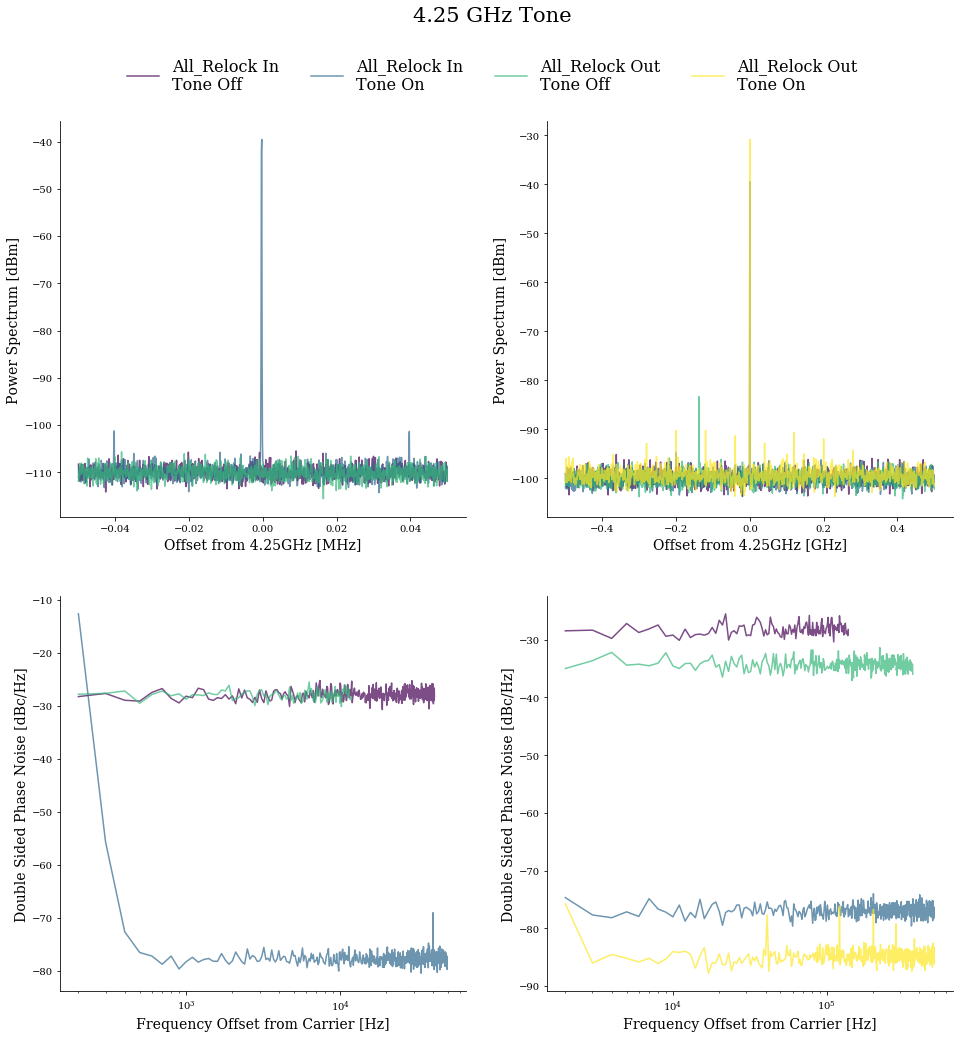

In [8]:
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
viridis = cm.get_cmap('viridis', 4)
colors = viridis(range(4))

dirname = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210226/Baseline'
sa100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)
cmapn = 0

for k1 in ['All_Relock']:
    if 'In' in out_dict['Baseline']['4.25_GHz'][k1].keys():
        for k2 in out_dict['Baseline']['4.25_GHz'][k1].keys():
            for k3 in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                #if ~('100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2]['Tone On'].keys()):
                #    continue
                print(k1,k2,k3)
                if '100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['100kHz BW']}"
                    f100k, p100k = read_csv(fname100k)
                    dat100k_plot = sub_spec(p100k,sa100k_p)
                    ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                             color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
                    ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                if '1MHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['1MHz BW']}"
                    f1M, p1M = read_csv(fname1M)
                    dat1M_plot = sub_spec(p1M,sa1M_p)
                    ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                             color = colors[cmapn], label = f'{k1} {k2}\n{k3}')
                    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
                    ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                cmapn += 1
    if not('In' in out_dict['Baseline']['4.25_GHz'][k1].keys()):
        fname100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1]['100kHz BW']}"
        fname1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1]['1MHz BW']}"
        f100k, p100k = read_csv(fname100k)
        dat100k_plot = sub_spec(p100k,sa100k_p)
        f1M, p1M = read_csv(fname1M)
        dat1M_plot = sub_spec(p1M,sa1M_p)
        ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
        ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
        ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        cmapn += 1

plt.suptitle('4.25 GHz Tone', fontsize = 21)

#plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(1, 2.45))
ax1.set_xlabel('Offset from 4.25GHz [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
#ax2.legend(frameon = False,fontsize = 16,ncol = 2)
ax2.set_xlabel('Offset from 4.25GHz [GHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0.8, 2.4))
#ax3.legend(frameon = False,fontsize = 16,ncol = 2)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax4.legend(frameon = False,fontsize = 16,ncol = 2)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)

##### All other tones tracking

NameError: name 'out_dict' is not defined

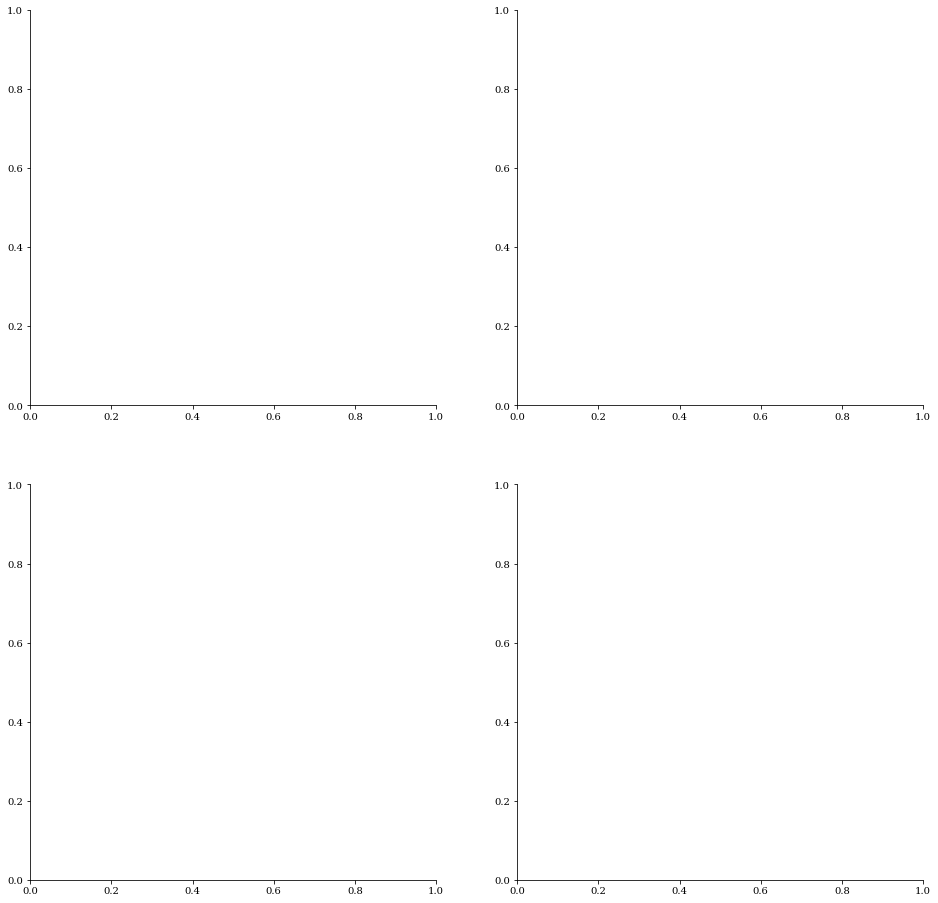

In [6]:
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
viridis = cm.get_cmap('viridis', 4)
colors = viridis(range(4))

dirname = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210226/Baseline'
sa100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)
cmapn = 0

for k1 in ['All_Tracking']:
    if 'In' in out_dict['Baseline']['4.25_GHz'][k1].keys():
        for k2 in out_dict['Baseline']['4.25_GHz'][k1].keys():
            for k3 in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                #if ~('100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2]['Tone On'].keys()):
                #    continue
                print(k1,k2,k3)
                if '100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['100kHz BW']}"
                    f100k, p100k = read_csv(fname100k)
                    dat100k_plot = sub_spec(p100k,sa100k_p)
                    ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                             color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
                    ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                if '1MHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2][k3].keys():
                    fname1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1][k2][k3]['1MHz BW']}"
                    f1M, p1M = read_csv(fname1M)
                    dat1M_plot = sub_spec(p1M,sa1M_p)
                    ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                             color = colors[cmapn], label = f'{k1} {k2}\n{k3}')
                    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
                    ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}\n{k3}')
                cmapn += 1
    if not('In' in out_dict['Baseline']['4.25_GHz'][k1].keys()):
        fname100k = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1]['100kHz BW']}"
        fname1M = f"{dirname}/{out_dict['Baseline']['4.25_GHz'][k1]['1MHz BW']}"
        f100k, p100k = read_csv(fname100k)
        dat100k_plot = sub_spec(p100k,sa100k_p)
        f1M, p1M = read_csv(fname1M)
        dat1M_plot = sub_spec(p1M,sa1M_p)
        ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                 color = colors[cmapn], label = f'{k1}')
        fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
        ax3.semilogx(fp100k[1:],pn100k[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
        ax4.semilogx(fp1M[1:],pn1M[1:],alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
        cmapn += 1

plt.suptitle('4.25 GHz Tone', fontsize = 21)
fig = plt.gcf()
fig.patch.set_facecolor('white')

#plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(1, 2.45))
ax1.set_xlabel('Offset from 4.25GHz [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
#ax2.legend(frameon = False,fontsize = 16,ncol = 2)
ax2.set_xlabel('Offset from 4.25GHz [GHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0.8, 2.4))
#ax3.legend(frameon = False,fontsize = 16,ncol = 2)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax4.legend(frameon = False,fontsize = 16,ncol = 2)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)

## Data from 2021-03-01

In [1]:
#For data taken w/ all channels on there are 1256 on
#1 AMC (AMC1) has LPF and other does not (one we're generating 4.25G Tone on)
out_dict = {}
out_dict['Baseline'] = {}
out_dict['Baseline']['122.88_MHz'] = {}
out_dict['Baseline']['122.88_MHz']['SA_Only'] = {}
out_dict['Baseline']['122.88_MHz']['SA_Only']['1MHz BW'] = 'Baseline_SA_122p88_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['SA_Only']['100kHz BW'] = 'Baseline_SA_122p88_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['With Filter'] = {}
out_dict['Baseline']['122.88_MHz']['With Filter']['100kHz BW'] = 'Baseline_Tone_122p88_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['With Filter']['1MHz BW'] = 'Baseline_Tone_122p88_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['10kHz 100mV Sine Mod'] = {}
out_dict['Baseline']['122.88_MHz']['10kHz 100mV Sine Mod']['100kHz BW'] = 'Mod100mVpp10kHz_122p88MHz_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['10kHz 100mV Sine Mod']['1MHz BW'] = 'Mod100mVpp10kHz_122p88MHz_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['100mV Noise Mod'] = {}
out_dict['Baseline']['122.88_MHz']['100mV Noise Mod']['100kHz BW'] = 'Mod100mVNoise_122p88_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['100mV Noise Mod']['1MHz BW'] = 'Mod100mVNoise_122p88_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['200mV Noise Mod'] = {}
out_dict['Baseline']['122.88_MHz']['200mV Noise Mod']['100kHz BW'] = 'Mod200mVNoise_122p88_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['200mV Noise Mod']['1MHz BW'] = 'Mod200mVNoise_122p88_1MHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['SG6000PRO'] = {}
out_dict['Baseline']['122.88_MHz']['SG6000PRO']['100kHz BW'] = 'SG6000PRO_122p88_100kHz_BW.csv'
out_dict['Baseline']['122.88_MHz']['SG6000PRO']['1MHz BW'] = 'SG6000PRO_122p88_1MHz_BW.csv'

out_dict['Baseline']['4.25_GHz'] = {}
out_dict['Baseline']['4.25_GHz']['SA_Only'] = {}
out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW'] = 'Baseline_SA_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW'] = 'Baseline_SA_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['All Off'] = {}
out_dict['Baseline']['4.25_GHz']['All Off']['In'] = {}
out_dict['Baseline']['4.25_GHz']['All Off']['In']['100kHz BW'] = 'Baseline_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['All Off']['In']['1MHz BW'] = 'Baseline_In_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['All Off']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['All Off']['Out']['100kHz BW'] = 'Baseline_Out_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['All Off']['Out']['1MHz BW'] = 'Baseline_Out_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod'] = {}
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['In'] = {}
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['In']['100kHz BW'] = 'Mod100mVpp10kHz_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['In']['1MHz BW'] = 'Mod100mVpp10kHz_In_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['Out']['100kHz BW'] = 'Mod100mVpp10kHz_Out_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['10kHz 100mV Sine Mod']['Out']['1MHz BW'] = 'Mod100mVpp10kHz_Out_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod'] = {}
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['In'] = {}
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['In']['100kHz BW'] = 'Mod100mVNoise_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['In']['1MHz BW'] = 'Mod100mVNoise_In_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['Out']['100kHz BW'] = 'Mod100mVNoise_Out_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['100mV Noise Mod']['Out']['1MHz BW'] = 'Mod100mVNoise_Out_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['In'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['In']['100kHz BW'] = 'Mod200mVNoise_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['In']['1MHz BW'] = 'Mod200mVNoise_In_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['Out']['100kHz BW'] = 'Mod200mVNoise_Out_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod']['Out']['1MHz BW'] = 'Mod200mVNoise_Out_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['In'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['In']['100kHz BW'] = 'Mod200mVNoise_dr14_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['In']['1MHz BW'] = 'Mod200mVNoise_dr14_In_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['Out']['100kHz BW'] = 'Mod200mVNoise_dr14_Out_4p25_100kHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['200mV Noise Mod\nDrive 14']['Out']['1MHz BW'] = 'Mod200mVNoise_dr14_Out_4p25_1MHz_BW.csv'
out_dict['Baseline']['4.25_GHz']['SG6000PRO'] = {}
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['In'] = {}
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['In']['100kHz BW'] = 'SG6000PRO_In_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['In']['1MHz BW'] = 'SG6000PRO_In_4p25_1MHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['Out'] = {}
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['Out']['100kHz BW'] = 'SG6000PRO_Out_4p25_100kHz_BW.csv' 
out_dict['Baseline']['4.25_GHz']['SG6000PRO']['Out']['1MHz BW'] = 'SG6000PRO_Out_4p25_1MHz_BW.csv' 

In [2]:
with open('File_Organization.yml', 'w') as outfile:
    yaml.dump(out_dict, outfile, default_flow_style=False)

NameError: name 'yaml' is not defined

Text(0, 0.5, 'Double Sided Phase Noise [dBc/Hz]')

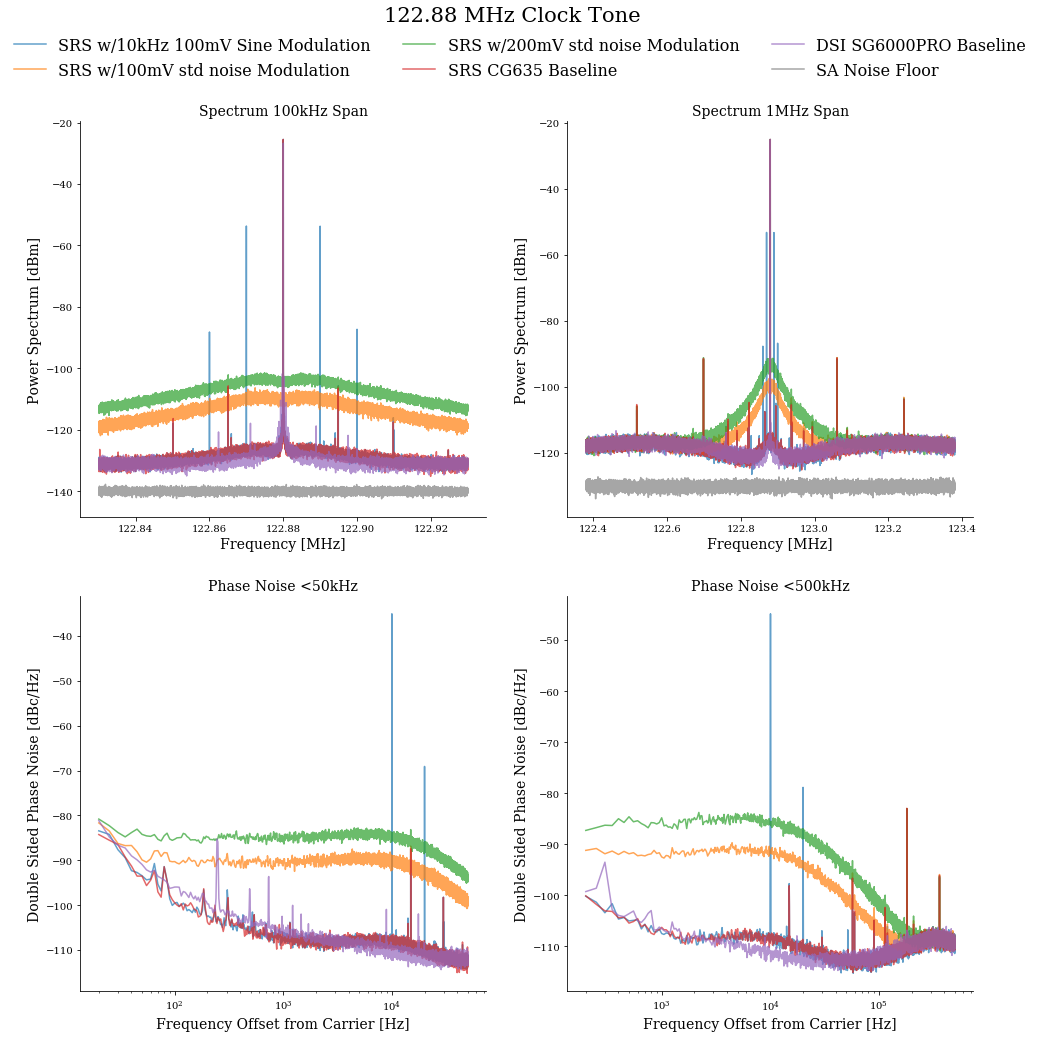

In [47]:
#Initialize plotting stuff.
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

#Get SA baseline noise to subtract away
dirname = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline'
sa100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)

#Iterate through all data to calc phase noise and plot
for k1 in ['10kHz 100mV Sine Mod','100mV Noise Mod','200mV Noise Mod','With Filter','SG6000PRO']:
    fname100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['100kHz BW']}"
    fname1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['1MHz BW']}"
    f100k, p100k = read_csv(fname100k)
    dat100k_plot = sub_spec(p100k,sa100k_p)
    f1M, p1M = read_csv(fname1M)
    dat1M_plot = sub_spec(p1M,sa1M_p)
    ax1.plot(f100k/1e6,dat100k_plot,alpha = 0.7,label = f'{k1}')
    ax2.plot(f1M/1e6,dat1M_plot,alpha = 0.7,label = f'{k1}')
    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
    ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,label = f'{k1}')
    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
    ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,label = f'{k1}')
plt.suptitle('122.88 MHz Clock Tone', fontsize = 21)
fig = plt.gcf()
fig.patch.set_facecolor('white')

ax1.plot(sa100k_f/1e6, sa100k_p,
         label = 'Spectrum Analyzer\nNoise Floor',
         color = 'grey',alpha = .7)
ax1.legend(['SRS w/10kHz 100mV Sine Modulation',
            'SRS w/100mV std noise Modulation',
            'SRS w/200mV std noise Modulation',
            'SRS CG635 Baseline',
            'DSI SG6000PRO Baseline',
            'SA Noise Floor'],loc = 'upper left',
           frameon = False, fontsize = 16, 
           ncol = 3,bbox_to_anchor=(-0.2, 1.25))
ax1.set_title('Spectrum 100kHz Span',fontsize = 14)
ax1.set_xlabel('Frequency [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax2.plot(sa1M_f/1e6, sa1M_p,
         label = 'Spectrum Analyzer\nNoise Floor',
         color = 'grey',alpha = 0.7)
ax2.set_title('Spectrum 1MHz Span',fontsize = 14)
ax2.set_xlabel('Frequency [MHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax3.set_title('Phase Noise <50kHz',fontsize = 14)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
ax4.set_title('Phase Noise <500kHz',fontsize = 14)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline/SG6000PRO_Out_4p25_100kHz_BW.csv
/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline/SG6000PRO_Out_4p25_1MHz_BW.csv


Text(150.0, -102.80862327039404, 'Median@30kHz\n-99.3 dBc/Hz')

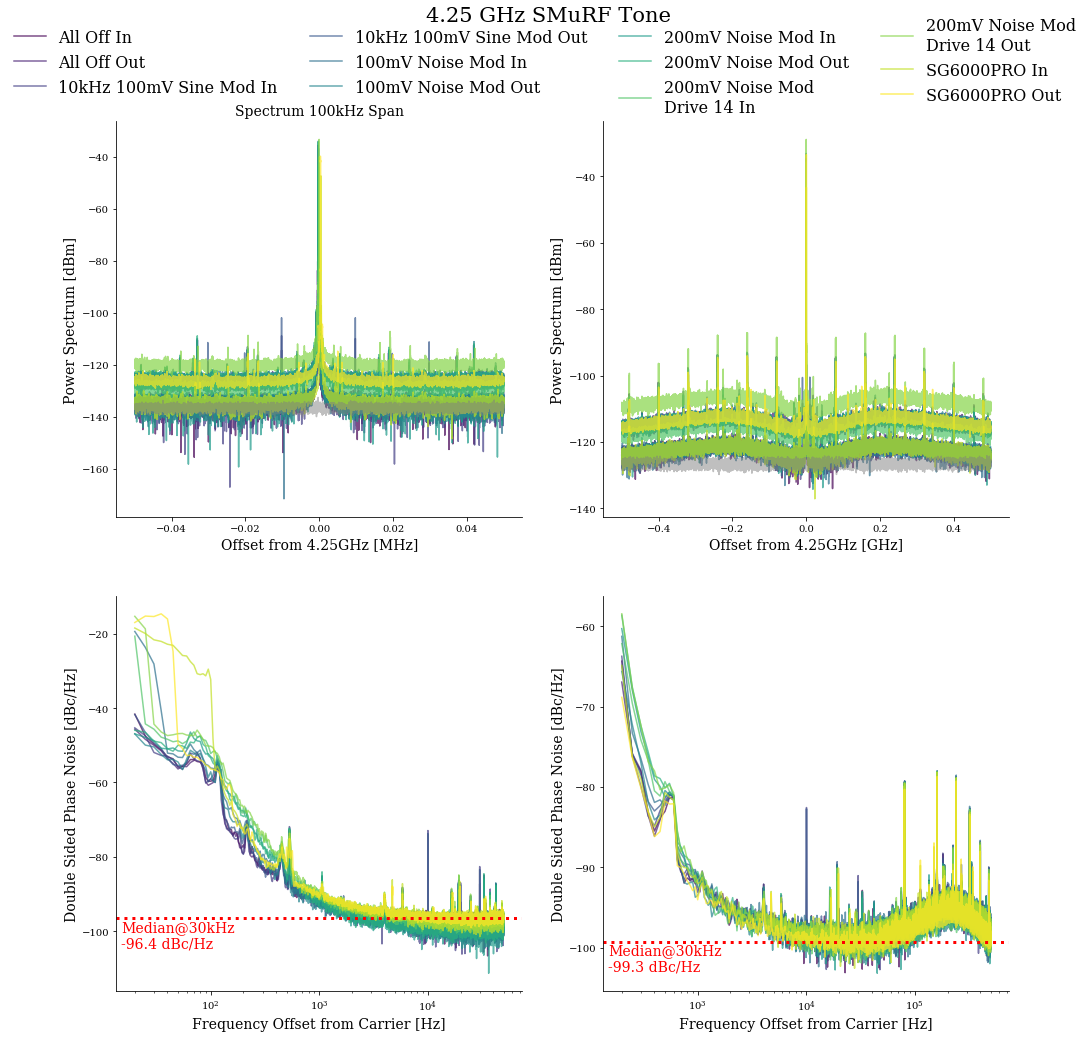

In [48]:
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
viridis = cm.get_cmap('viridis', 12)
colors = viridis(range(12))

dir = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline'
sa100k = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)
cmapn = 0

for k1 in ['All Off','10kHz 100mV Sine Mod','100mV Noise Mod','200mV Noise Mod','200mV Noise Mod\nDrive 14','SG6000PRO']:
    if 'In' in out_dict['Baseline']['4.25_GHz'][k1].keys():
        for k2 in out_dict['Baseline']['4.25_GHz'][k1].keys():
            #for k3 in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                #if ~('100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2]['Tone On'].keys()):
                #    continue
                if '100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                    fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2]['100kHz BW']}"
                    f100k, p100k = read_csv(fname100k)
                    if len(p100k) > 0:
                        dat100k_plot = sub_spec(p100k,sa100k_p)
                        ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}')
                        fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
                        ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,
                                     color = colors[cmapn],label = f'{k1} {k2}')
                if '1MHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                    fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2]['1MHz BW']}"
                    f1M, p1M = read_csv(fname1M)
                    dat1M_plot = sub_spec(p1M,sa1M_p)
                    ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                             color = colors[cmapn], label = f'{k1} {k2}')
                    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
                    ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}')
                cmapn += 1
    if not('In' in out_dict['Baseline']['4.25_GHz'][k1].keys()):
        fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['100kHz BW']}"
        fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['1MHz BW']}"
        f100k, p100k = read_csv(fname100k)
        if len(p100k) > 0:
            dat100k_plot = sub_spec(p100k,sa100k_p)
            f1M, p1M = read_csv(fname1M)
            dat1M_plot = sub_spec(p1M,sa1M_p)
            ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
            ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
            fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
            ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,
                         color = colors[cmapn], label = f'{k1}')
            fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
            ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,
                         color = colors[cmapn], label = f'{k1}')
            cmapn += 1

plt.suptitle('4.25 GHz SMuRF Tone', fontsize = 21)
fig = plt.gcf()
fig.patch.set_facecolor('white')

#plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0, 2.45))
ax1.plot((sa100k_f-4.25e9)/1e6, sa100k_p, color = 'grey',alpha = 0.5)
ax1.set_xlabel('Offset from 4.25GHz [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax1.set_title('Spectrum 100kHz Span',fontsize = 14)
#ax2.legend(frameon = False,fontsize = 16,ncol = 2)
ax2.plot((sa1M_f-4.25e9)/1e6, sa1M_p, color = 'grey',alpha = 0.5)
ax2.set_xlabel('Offset from 4.25GHz [GHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
plt.legend(frameon = False,fontsize = 16,ncol = 4,
           bbox_to_anchor=(1.2, 2.5))
#ax3.legend(frameon = False,fontsize = 16,ncol = 2)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax3.axhline(-100,ls = ':',color = 'k',lw = 3)
#ax3.axhline(-100,ls = ':',color = 'k',lw = 3)
pnmed = np.median(pn100k[np.where(((fp100k > 1e4) & (fp100k < 5e4)))])
print(fname100k)
ax3.axhline(pnmed,ls = ':',color = 'r',lw = 3)
ax3.text(1.5e1,pnmed-8,
         f'Median@30kHz\n{np.round(pnmed,1)} dBc/Hz',
         color = 'r',fontsize = 14)
#ax3.text(1.5e1,-103,'-100 dBc/Hz',
#         fontsize = 14)
#ax4.legend(frameon = False,fontsize = 16,ncol = 2)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax4.axhline(-100,ls = ':',color = 'k',lw = 3)
pnmed = np.median(pn1M[np.where(((fp1M > 1e4) & (fp1M < 5e4)))])
print(fname1M)
ax4.axhline(pnmed,ls = ':',color = 'r',lw = 3)
ax4.text(1.5e2,pnmed-3.5,
         f'Median@30kHz\n{np.round(pnmed,1)} dBc/Hz',
         color = 'r',fontsize = 14)
#ax4.text(1.5e2,-102,'-100 dBc/Hz',
#         fontsize = 14)

#### Compare SRS CG635 to DSI SG6000PRO

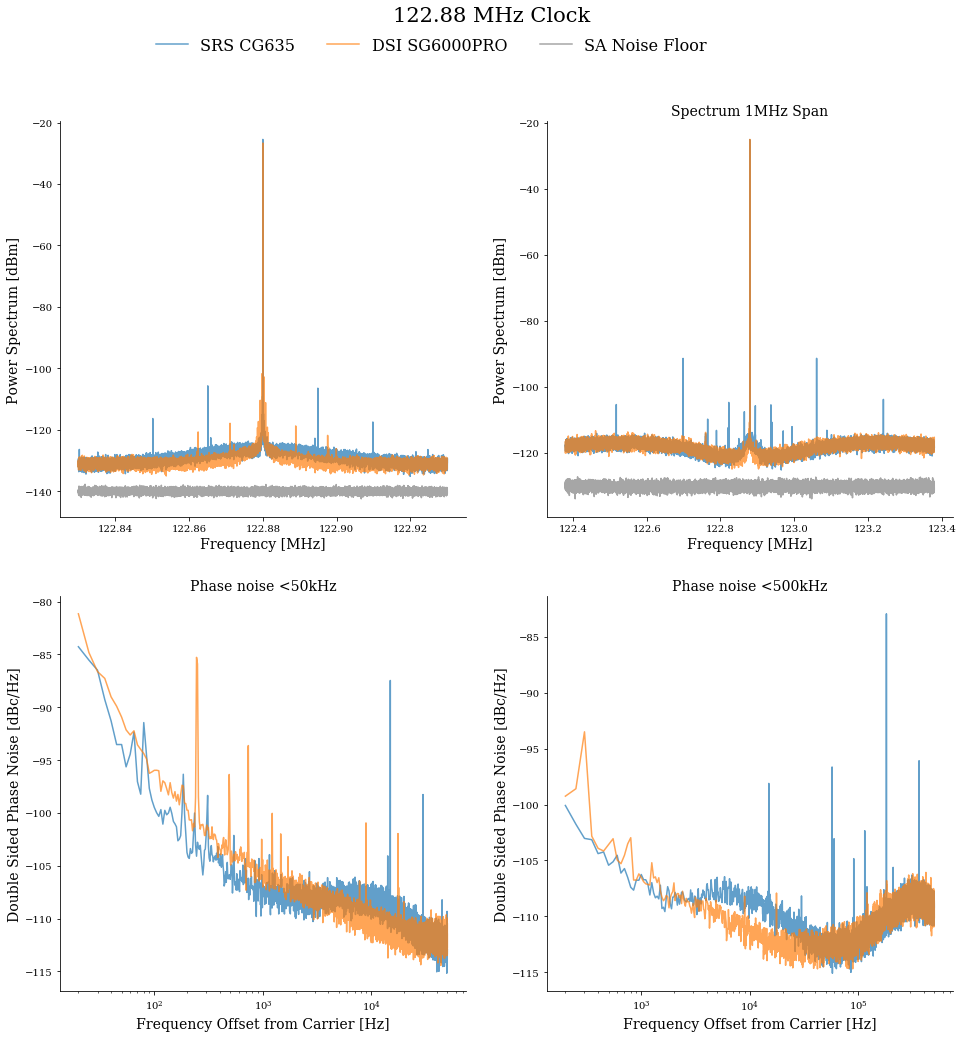

In [9]:
#Initialize plotting stuff.
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)

#Get SA baseline noise to subtract away
dirname = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline'
sa100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)

#Iterate through all data to calc phase noise and plot
for k1 in ['With Filter','SG6000PRO']:
    fname100k = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['100kHz BW']}"
    fname1M = f"{dirname}/{out_dict['Baseline']['122.88_MHz'][k1]['1MHz BW']}"
    f100k, p100k = read_csv(fname100k)
    dat100k_plot = sub_spec(p100k,sa100k_p)
    f1M, p1M = read_csv(fname1M)
    dat1M_plot = sub_spec(p1M,sa1M_p)
    ax1.plot(f100k/1e6,dat100k_plot,alpha = 0.7,label = f'{k1}')
    ax2.plot(f1M/1e6,dat1M_plot,alpha = 0.7,label = f'{k1}')
    fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
    ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,label = f'{k1}')
    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
    ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,label = f'{k1}')
plt.suptitle('122.88 MHz Clock', fontsize = 21)
fig = plt.gcf()
fig.patch.set_facecolor('white')

ax1.plot(sa100k_f/1e6, sa100k_p,
         label = 'Spectrum Analyzer\nNoise Floor',
         color = 'grey',alpha = .7)
ax1.legend(['SRS CG635','DSI SG6000PRO','SA Noise Floor'],
           loc = 'upper left',frameon = False, fontsize = 16, 
           ncol = 3,bbox_to_anchor=(0.2, 1.25))
ax1.set_xlabel('Frequency [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax2.plot(sa1M_f/1e6, sa1M_p,
         label = 'Spectrum Analyzer\nNoise Floor',
         color = 'grey',alpha = 0.7)
#ax2.legend(loc = 'upper left',frameon = False,
#           fontsize = 16,ncol = 2)
ax2.set_xlabel('Frequency [MHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax2.set_title('Spectrum 1MHz Span',fontsize = 14)
#ax3.legend(frameon = False,fontsize = 16)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
ax3.set_title('Phase noise <50kHz',fontsize = 14)
#ax4.legend(frameon = False,fontsize = 16)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
ax4.set_title('Phase noise <500kHz',fontsize = 14)

plt.savefig('/home/msilvafe/Pictures/Clock_Noise_Compare.png')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]


/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline/SG6000PRO_Out_4p25_100kHz_BW.csv
/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline/SG6000PRO_Out_4p25_1MHz_BW.csv


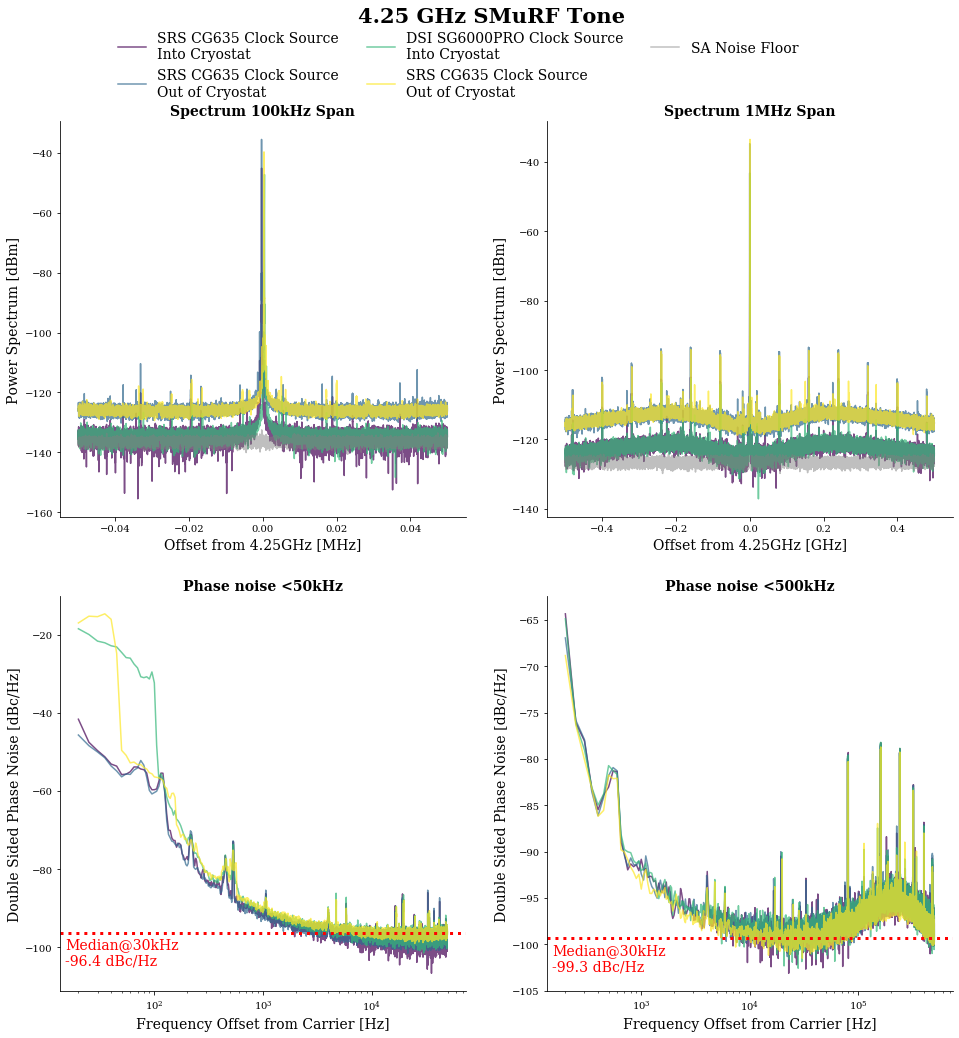

In [10]:
plt.figure(figsize = (16,16))
ax1  = plt.subplot(2,2,1)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2 = plt.subplot(2,2,2)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax3 = plt.subplot(2,2,3)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax4 = plt.subplot(2,2,4)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
viridis = cm.get_cmap('viridis', 4)
colors = viridis(range(4))

dir = '/home/msilvafe/Documents/SMuRF_Clock_Phase_Noise/20210301/Baseline'
sa100k = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['100kHz BW']}"
sa100k_f, sa100k_p = read_csv(sa100k)
sa1M = f"{dir}/{out_dict['Baseline']['4.25_GHz']['SA_Only']['1MHz BW']}"
sa1M_f, sa1M_p = read_csv(sa1M)
cmapn = 0

for k1 in ['All Off','SG6000PRO']:
    if 'In' in out_dict['Baseline']['4.25_GHz'][k1].keys():
        for k2 in out_dict['Baseline']['4.25_GHz'][k1].keys():
            #for k3 in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                #if ~('100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2]['Tone On'].keys()):
                #    continue
                if '100kHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                    fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2]['100kHz BW']}"
                    f100k, p100k = read_csv(fname100k)
                    if len(p100k) > 0:
                        dat100k_plot = sub_spec(p100k,sa100k_p)
                        ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}')
                        fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
                        ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,
                                     color = colors[cmapn],label = f'{k1} {k2}')
                if '1MHz BW' in out_dict['Baseline']['4.25_GHz'][k1][k2].keys():
                    fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1][k2]['1MHz BW']}"
                    f1M, p1M = read_csv(fname1M)
                    dat1M_plot = sub_spec(p1M,sa1M_p)
                    ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                             color = colors[cmapn], label = f'{k1} {k2}')
                    fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
                    ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,
                                 color = colors[cmapn],label = f'{k1} {k2}')
                cmapn += 1
    if not('In' in out_dict['Baseline']['4.25_GHz'][k1].keys()):
        fname100k = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['100kHz BW']}"
        fname1M = f"{dir}/{out_dict['Baseline']['4.25_GHz'][k1]['1MHz BW']}"
        f100k, p100k = read_csv(fname100k)
        if len(p100k) > 0:
            dat100k_plot = sub_spec(p100k,sa100k_p)
            f1M, p1M = read_csv(fname1M)
            dat1M_plot = sub_spec(p1M,sa1M_p)
            ax1.plot((f100k-4.25e9)/1e6,dat100k_plot,alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
            ax2.plot((f1M-4.25e9)/1e6,dat1M_plot,alpha = 0.7,
                     color = colors[cmapn], label = f'{k1}')
            fp100k,pn100k = get_phase_noise(f100k,dat100k_plot,3)
            ax3.semilogx(fp100k[3:],pn100k[3:],alpha = 0.7,
                         color = colors[cmapn], label = f'{k1}')
            fp1M,pn1M = get_phase_noise(f1M,dat1M_plot,30)
            ax4.semilogx(fp1M[3:],pn1M[3:],alpha = 0.7,
                         color = colors[cmapn], label = f'{k1}')
            cmapn += 1

plt.suptitle('4.25 GHz SMuRF Tone', fontsize = 21,fontweight = 1000)
fig = plt.gcf()
fig.patch.set_facecolor('white')

#plt.legend(frameon = False,fontsize = 16,ncol = 5,bbox_to_anchor=(0, 2.45))
ax1.plot((sa100k_f-4.25e9)/1e6, sa100k_p, color = 'grey',alpha = 0.5)
ax1.set_xlabel('Offset from 4.25GHz [MHz]',fontsize = 14)
ax1.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax1.set_title('Spectrum 100kHz Span',fontsize = 14,fontweight = 1000)
ax1.legend(['SRS CG635 Clock Source\nInto Cryostat',
            'SRS CG635 Clock Source\nOut of Cryostat',
            'DSI SG6000PRO Clock Source\nInto Cryostat',
            'SRS CG635 Clock Source\nOut of Cryostat',
            'SA Noise Floor'],frameon = False,
           fontsize = 14,ncol = 3,
           bbox_to_anchor=(1.85, 1.26))
#ax2.legend(frameon = False,fontsize = 16,ncol = 2)
ax2.plot((sa1M_f-4.25e9)/1e6, sa1M_p, color = 'grey',alpha = 0.5)
ax2.set_xlabel('Offset from 4.25GHz [GHz]',fontsize = 14)
ax2.set_ylabel('Power Spectrum [dBm]',fontsize = 14)
ax2.set_title('Spectrum 1MHz Span',fontsize = 14,fontweight = 1000)
#ax3.legend(frameon = False,fontsize = 16,ncol = 2)
ax3.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax3.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax3.axhline(-100,ls = ':',color = 'k',lw = 3)
#ax3.axhline(-100,ls = ':',color = 'k',lw = 3)
pnmed = np.median(pn100k[np.where(((fp100k > 1e4) & (fp100k < 5e4)))])
print(fname100k)
ax3.axhline(pnmed,ls = ':',color = 'r',lw = 3)
ax3.text(1.5e1,pnmed-8,
         f'Median@30kHz\n{np.round(pnmed,1)} dBc/Hz',
         color = 'r',fontsize = 14)
ax3.set_title('Phase noise <50kHz',fontsize = 14,fontweight = 1000)
ax4.set_xlabel('Frequency Offset from Carrier [Hz]',fontsize = 14)
ax4.set_ylabel('Double Sided Phase Noise [dBc/Hz]',fontsize = 14)
#ax4.axhline(-100,ls = ':',color = 'k',lw = 3)
pnmed = np.median(pn1M[np.where(((fp1M > 1e4) & (fp1M < 5e4)))])
print(fname1M)
ax4.axhline(pnmed,ls = ':',color = 'r',lw = 3)
ax4.text(1.5e2,pnmed-3.5,
         f'Median@30kHz\n{np.round(pnmed,1)} dBc/Hz',
         color = 'r',fontsize = 14)
ax4.set_title('Phase noise <500kHz',fontsize = 14,fontweight = 1000)

plt.savefig('/home/msilvafe/Pictures/Clock_Noise_Compare_SMuRF_Tone.png')